# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [36]:
import os
import re
#!pip install emoji
import emoji
#!pip install pandas
import pandas as pd

from collections import Counter, defaultdict
#!pip install nltk
#!pip install punctuation
from nltk.corpus import stopwords
from string import punctuation
#!pip install WordCloud

from wordcloud import WordCloud 
#!pip install sklearn
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
try:
    sw = stopwords.words("english")
except:
    from nltk import download as nltkdl
    nltkdl('stopwords')
    sw =  stopwords.words("english")


In [2]:
# Use this space for any additional import statements you need



In [38]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
      # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = len("".join(tokens))
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        
    return([num_tokens,num_unique_tokens,num_characters,
            lexical_diversity])
     
def is_emoji(s):
    return(s in all_language_emojis)

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    goodtokens=[]
    for word in tokens:
        if not word in sw:
            goodtokens.append(word)
    return(goodtokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    tokens= text.split()
    return(tokens)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [21]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'rihanna':'rihanna_followers_data.txt',
                'taylorswift13':'taylorswift13_followers_data.txt'}


In [22]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['taylorswift13'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "taylorswift13"

In [23]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['rihanna'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "rihanna"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [24]:
# read in the lyrics here
#songbank={}
#or artist in os.listdir("lyrics"):
 #   artist_path=os.path.join('lyrics',artist)
  #  for lyric_file in os.listdir(artist_path):
   #     artist_path=os.path.join('lyrics',artist,lyric_file)
    #    f=open(artist_path,'r')
     #   artist_song=lyric_file.replace('.txt','').split('_')
      #  songbank[artist_song[0],artist_song[1],'lyrics']=f.read()
       # f.close()


In [39]:

songbank = []
for artistName in os.listdir("lyrics"):
    artist_path = os.path.join('lyrics',artistName)
    for lyric_file in os.listdir(artist_path):
        song_path = os.path.join('lyrics',artistName,lyric_file)
        with open(song_path, 'r') as f:
            songName = lyric_file.replace('.txt','').split('_')[-1]
            lyrics = f.read()
            songbank.append({
                "song_name": songName,
                "artist": artistName,
                "lyrics": lyrics,
            })

# create pandas dataframe
lyrics_data = pd.DataFrame(songbank)
lyrics_data.head()


,song_name,artist,lyrics
0,breakitoff,rihanna,Break It Off\n\n\n\nBreaking it off and settin...
1,crazylittlethingcalledlove,rihanna,"Crazy Little Thing Called Love\n\n\n\nOoh, yea..."
2,demhaters,rihanna,Dem Haters\n\nI'm not concerned with people\nW...
3,finalgoodbye,rihanna,Final Goodbye\n\nI never should've waited so l...
4,hereigoagain,rihanna,Here I Go Again\n\nNa-na-na-na-na\nNa-na-na-na...


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove punctuation
* Split on whitespace
* Remove stopwords (optional)

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove punctuation other than emojis or hashtags
* Split on whitespace
* Remove stopwords

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [40]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [41]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [42]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
3018,taylorswift13,Barbz 🦄 stream #DWHAP #Bussin #BlickBlick,"[barbz, 🦄, stream, #dwhap, #bussin, #blickblick]"
3003,taylorswift13,you are the one you should love💜,"[one, love💜]"
4141,taylorswift13,💫💥,[💫💥]
3889,taylorswift13,This Love (Taylor’s Version) Out Now! 💙,"[love, taylor’s, version, 💙]"
3974,rihanna,🌹,[🌹]
3975,taylorswift13,❤️,[❤️]
3513,taylorswift13,Barbz 🦄 stream #DWHAP #Bussin #BlickBlick,"[barbz, 🦄, stream, #dwhap, #bussin, #blickblick]"
543,taylorswift13,Barbz 🦄 stream #DWHAP #Bussin #BlickBlick,"[barbz, 🦄, stream, #dwhap, #bussin, #blickblick]"
5073,rihanna,Becoming a philanthropist is my second nature....,"[becoming, philanthropist, second, nature, see..."
3297,taylorswift13,"Be Confident , Be yourself 📍CEB 🇵🇭II 💉 RN II ♍...","[confident, 📍ceb, 🇵🇭ii, 💉, rn, ii, ♍️, virgo]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: Using profanity filters and inappropriate language to create clean lyrics. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [60]:
# your code here
def descriptive_stats(tokens, num_tokens = 5, verbose=False) :

  # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = len("".join(tokens))
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        
    return([num_tokens,num_unique_tokens,num_characters,
            lexical_diversity])

#lyrics_data["lexical diversity"] = lyrics_data["tokens"].map(descriptive_stats[3])

#(
 #   lyrics_data["token_count"],
  #  lyrics_data["unique_tokens"],
   # lyrics_data["character_count"],
    #lyrics_data["lexical_diversity"],
#) = *lyrics_data["lyrics"].map(descriptive_stats)
#lyrics_data.head()

def token_count_stats(tokens):
    return descriptive_stats(tokens)[0]
def unique_token_stats(tokens):
    return descriptive_stats(tokens)[1]
def character_count_stats(tokens):
    return descriptive_stats(tokens)[2]
def lexical_diversity_stats(tokens):
    return descriptive_stats(tokens)[3]


lyrics_data["token_count"] = lyrics_data["tokens"].map(token_count_stats)
lyrics_data["unique_tokens"] = lyrics_data["tokens"].map(unique_token_stats)
lyrics_data["character_count"] = lyrics_data["tokens"].map(character_count_stats)
lyrics_data["lexical_diversity"] = lyrics_data["tokens"].map(lexical_diversity_stats)
lyrics_data.head()

,song_name,artist,lyrics,tokens,num_tokens,statistics,token_count,unique_tokens,character_count,lexical_diversity
0,breakitoff,rihanna,Break It Off\n\n\n\nBreaking it off and settin...,"[break, breaking, setting, real, way, making, ...",434,"[434, 155, 1814, 0.35714285714285715]",434,155,1814,0.357143
1,crazylittlethingcalledlove,rihanna,"Crazy Little Thing Called Love\n\n\n\nOoh, yea...","[crazy, little, thing, called, love, ooh, yeah...",271,"[271, 98, 1360, 0.36162361623616235]",271,98,1360,0.361624
2,demhaters,rihanna,Dem Haters\n\nI'm not concerned with people\nW...,"[dem, haters, im, concerned, people, prey, wea...",210,"[210, 73, 998, 0.3476190476190476]",210,73,998,0.347619
3,finalgoodbye,rihanna,Final Goodbye\n\nI never should've waited so l...,"[final, goodbye, never, shouldve, waited, long...",110,"[110, 55, 501, 0.5]",110,55,501,0.500000
4,hereigoagain,rihanna,Here I Go Again\n\nNa-na-na-na-na\nNa-na-na-na...,"[go, nanananana, nanananana, nanananananananan...",225,"[225, 123, 1130, 0.5466666666666666]",225,123,1130,0.546667


In [72]:
taylorDF = lyrics_data[lyrics_data["artist"]!="rihanna"]
rihannaDF= lyrics_data[lyrics_data["artist"] =="rihanna"]
print('min lexical diversity of the lyrics data: ',min(lyrics_data['lexical_diversity']))
print(min(taylorDF['lexical_diversity']))
print(min(rihannaDF['lexical_diversity']))

min lexical diversity of the lyrics data:  0.16768916155419222
0.23444976076555024
0.16768916155419222


In [68]:
worstSong = lyrics_data[lyrics_data["lexical_diversity"]==min(lyrics_data["lexical_diversity"])]
worstSong.head()

,song_name,artist,lyrics,tokens,num_tokens,statistics,token_count,unique_tokens,character_count,lexical_diversity
15,thatlalala,rihanna,"That La, La, La\n\nHere we go\n(Oh) la, la, la...","[la, la, la, go, oh, la, la, la, la, la, yeah,...",489,"[489, 82, 1681, 0.16768916155419222]",489,82,1681,0.167689


In [69]:
taylorworstSong = taylorDF[taylorDF["lexical_diversity"]==min(taylorDF["lexical_diversity"])]
taylorworstSong.head()

,song_name,artist,lyrics,tokens,num_tokens,statistics,token_count,unique_tokens,character_count,lexical_diversity
42,untouchable,taylorswift,Untouchable\n\nUntouchable like a distant diam...,"[untouchable, untouchable, like, distant, diam...",209,"[209, 49, 1040, 0.23444976076555024]",209,49,1040,0.23445


Q: what observations do you make about these data? 

A: Taylor has more lexical diversity. However both of them have low lexical diversity. This may be due to the fact that they use words that fill in spaces in songs. I think that if the words la and oh were removed from the songs then we can get a more accurate representation of the lexical diversity. 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents, if we view each data source as a single document, or too many, if we view each description as a separate document. In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To get around this, we find tokens for each corpus that match the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.


In [91]:
# your code here
corpus= lyrics_data['tokens'][0]

from itertools import chain
corpuses = list(chain.from_iterable(lyrics_data['tokens'][0:]))


def wordCounts(tokens,n,top=10):
    # get a count of word occurances
    tokenDict = {}
    for t in tokens:
        if t not in tokenDict:
            tokenDict[t] = 1
        else:
            tokenDict[t] += 1
    # turn dictionary into list (so that its ordered)
    tokenList = []
    for word, occurances in tokenDict.items():
        if occurances>=n:
            tokenList.append([word, occurances])
    # sort the tokenlist
    tokenList = sorted(tokenList, key=lambda l: l[1], reverse=True)
     # only return the top X occurnaces
    return tokenList[:top]
x= wordCounts(corpuses,n=5, top=10)
#print(lyrics_data['song_name'][0:10])
print(x)

[['im', 177], ['oh', 174], ['dont', 166], ['know', 161], ['come', 152], ['let', 133], ['baby', 123], ['got', 108], ['time', 106], ['boy', 102]]


In [99]:
# your code here

from itertools import chain
corpuses = list(chain.from_iterable(rihannaDF['tokens'][0:]))
x= wordCounts(corpuses,n=5, top=10)
print('rihannas favorite words:', x)

rihannas favorite words: [['dont', 131], ['oh', 126], ['let', 120], ['know', 119], ['come', 114], ['im', 113], ['boy', 98], ['la', 96], ['turn', 94], ['got', 92]]


In [101]:
# your code here

from itertools import chain
corpuses = list(chain.from_iterable(taylorDF['tokens'][0:]))
x= wordCounts(corpuses,n=5, top=10)
print(f"taylor's favorite words:",x)

taylor's favorite words: [['im', 64], ['oh', 48], ['youre', 48], ['know', 42], ['come', 38], ['like', 36], ['dont', 35], ['baby', 34], ['wanna', 33], ['think', 32]]


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Rihanna uses the word don't the most meaning she has alot of regret. Taylor uses the word I'm alot because she talks about herself and her feelings. Oh is their second favorite word for both artists which is expected because it fills in empty beats in songs. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [102]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

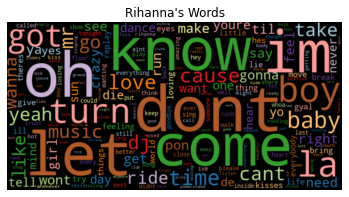

In [107]:
from itertools import chain
corpuses = list(chain.from_iterable(rihannaDF["tokens"]))
wordFreqList = wordCounts(corpuses, n=5, top=200)
#print("Rihanna's favorite words", wordFreqList)
# [ ["dont", 234], ["oh", 82], ... ]

################

wordFreqDict = {}
# { "dont": 234,  "oh":82,  ... }

for wf in wordFreqList:
    word = wf[0]
    count = wf[1]
    wordFreqDict[word] = count

wordcloud(
    word_freq=wordFreqDict,
    title="Rihanna's Words",
    max_words=200,
    stopwords=None
)

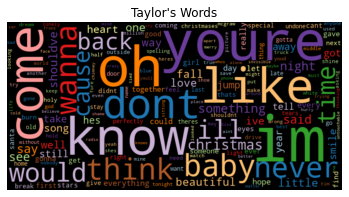

In [109]:
from itertools import chain
corpuses = list(chain.from_iterable(taylorDF["tokens"]))
wordFreqList = wordCounts(corpuses, n=5, top=200)
#print("Rihanna's favorite words", wordFreqList)
# [ ["dont", 234], ["oh", 82], ... ]

################

wordFreqDict = {}
# { "dont": 234,  "oh":82,  ... }

for wf in wordFreqList:
    word = wf[0]
    count = wf[1]
    wordFreqDict[word] = count

wordcloud(
    word_freq=wordFreqDict,
    title="Taylor's Words",
    max_words=200,
    stopwords=None
)

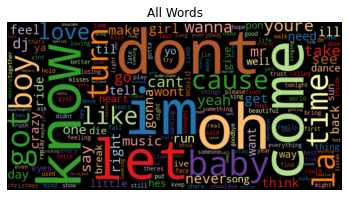

In [110]:
from itertools import chain
corpuses = list(chain.from_iterable(lyrics_data["tokens"]))
wordFreqList = wordCounts(corpuses, n=5, top=200)
#print("Rihanna's favorite words", wordFreqList)
# [ ["dont", 234], ["oh", 82], ... ]

################

wordFreqDict = {}
# { "dont": 234,  "oh":82,  ... }

for wf in wordFreqList:
    word = wf[0]
    count = wf[1]
    wordFreqDict[word] = count

wordcloud(
    word_freq=wordFreqDict,
    title="All Words",
    max_words=200,
    stopwords=None
)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: 